# This is the fourth step in project.

Motivaton: To Train improvised model.

Final output: Accuracy and feature importance of improvised model.

In [1]:
# import required libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
import xgboost as xgb
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score
import shap
warnings.simplefilter("ignore", UserWarning)
pd.options.mode.chained_assignment = None

In [2]:
# file path
ROOT = os.path.join(os.getcwd(), 'Statsbomb_data\open-data-master')
DATA = os.path.join(ROOT, 'data')
FINAL_DF = os.path.join(ROOT,'final_dataframes')

# Preparing Data

In [16]:
''' Load the dataset prepared in data_prep_3

Variables:-
FINAL_DF - string - file path to all pickle files
'''
df = pd.read_pickle(
    filepath_or_buffer=os.path.join(FINAL_DF,'engineered_features.pkl')
)
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

In [17]:
print(f'Number of rows in dataframe: {df.shape[0]}')

Number of rows in dataframe: 21799


In [18]:
df.head(2)

,id,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,...,player_name,outcome,body_part,body_part_strong,wpa,dfg,angle,freeze_frame,gk_distance,specific_position
0,682270cc-4bc4-4952-8f91-d3c5a704a691,1,00:02:33.865,2,33,"{'id': 16, 'name': 'Shot'}",7,"{'id': 24, 'name': 'Liverpool'}","{'id': 4, 'name': 'From Throw In'}","{'id': 24, 'name': 'Liverpool'}",...,Georginio Wijnaldum,Blocked,Right Foot,NaN,False,0.303792,0.088568,"[{'location': [98.0, 48.4], 'player': {'id': 5...",0.054478,Midfield
1,9f5aa3eb-3bed-4bc0-97a5-bb8444b235b9,1,00:05:14.065,5,14,"{'id': 16, 'name': 'Shot'}",13,"{'id': 24, 'name': 'Liverpool'}","{'id': 3, 'name': 'From Free Kick'}","{'id': 24, 'name': 'Liverpool'}",...,Mohamed Salah,Blocked,Left Foot,Left Foot,False,0.316782,0.087038,"[{'location': [109.0, 39.9], 'player': {'id': ...",0.031847,Attack


Matches df is loaded to join seasons in final dataframe

In [21]:
''' Loading matches data from prep_data_1

Variables:-
FINAL_DF - string - file path to all pickles files
matches_df - DataFrame - matches dataframe
'''
matches_df = pd.read_pickle(
    filepath_or_buffer=os.path.join(FINAL_DF,'matches.pkl')
)
matches_df['season_name'] = matches_df['season'].str['season_name']

In [22]:
matches_df = matches_df[['match_id','season_name']]
print(f"There are {matches_df.shape[0]} matches")

There are 885 matches


In [23]:
''' join seasons data with other data.

Variables:-
matches_df - DataFrame - matches dataframe
df - DataFrame - data with all features for training improvised model
'''
df = df.set_index('match_id',drop=False).join(
    other = matches_df.set_index('match_id'),
    how = 'left'
)

In [24]:
df.head(2)

,id,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,...,outcome,body_part,body_part_strong,wpa,dfg,angle,freeze_frame,gk_distance,specific_position,season_name
match_id,,,,,,,,,,,,,,,,,,,,,
9575,c0379c08-56ba-4cd5-a1b8-a17175132b30,1,00:02:19.699,2,19,"{'id': 16, 'name': 'Shot'}",6,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",...,Off T,Right Foot,Right Foot,False,0.123319,0.230500,"[{'location': [108.6, 37.5], 'player': {'id': ...",0.016343,Midfield,2017/2018
9575,b6b64f49-b4f5-41cd-901a-8249a1725b02,1,00:03:38.084,3,38,"{'id': 16, 'name': 'Shot'}",8,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",...,Off T,Left Foot,Left Foot,False,0.263869,0.104921,"[{'location': [103.8, 53.0], 'player': {'id': ...",0.019697,Attack,2017/2018


Baseline model's data is also loaded to merge previous features with improvised features.

In [25]:
''' Loading baseline model's data.

Variables:-
FINAL_DF - string - file path to all pickles files
'''
baseline_df = pd.read_pickle(
    filepath_or_buffer=os.path.join(FINAL_DF,'final_df.pkl')
)

In [26]:
baseline_df.head(2)

,event_id,player,first_touch,open_goal,under_pressure,shot_technique,shot_body_part,statsbomb_xg,goal,aerial_shot,from_play,one_v_one
0,682270cc-4bc4-4952-8f91-d3c5a704a691,Georginio Wijnaldum,False,False,False,Normal,Right Foot,0.036399,False,True,Throw In,False
1,9f5aa3eb-3bed-4bc0-97a5-bb8444b235b9,Mohamed Salah,True,False,True,Normal,Left Foot,0.027976,False,True,Free Kick,False


In [27]:
print(f"Improvised dataframe rows: {df.shape[0]}\nBaseline dataframe rows: {baseline_df.shape[0]}")

Improvised dataframe rows: 21799
Baseline dataframe rows: 21777


In [28]:
''' Join improvised features with baseline features.

Variables:-
baseline_df - DataFrame - dataframe used to train the baseline model.
df - DataFrame - data with all features for training improvised model
'''
final_df = baseline_df.set_index('event_id').join(
    other=df[['id','player_name','body_part_strong','wpa','dfg','angle','gk_distance','specific_position','season_name']].set_index('id'),
    how='left'
)

In [29]:
final_df.head(2)

,player,first_touch,open_goal,under_pressure,shot_technique,shot_body_part,statsbomb_xg,goal,aerial_shot,from_play,one_v_one,player_name,body_part_strong,wpa,dfg,angle,gk_distance,specific_position,season_name
00007fd2-738e-4b27-bb68-7bdeffc77ee7,Simão Pedro Fonseca Sabrosa,False,False,False,Normal,Right Foot,0.028562,False,True,Regular Play,False,Simão Pedro Fonseca Sabrosa,Right Foot,False,0.299676,0.078548,0.034351,Attack,2013/2014
00063e06-f8b7-437d-a431-30f7559ec7e2,Leandro Andrés Gioda,False,False,False,Normal,Head,0.093138,False,True,Free Kick,False,Leandro Andrés Gioda,NaN,False,0.121941,0.234524,0.016094,Defense,2009/2010


In [30]:
''' Encoding all binary categorical variables.

Variables:-
final_df - DataFrame - combined data of baseline and improvised features
'''
encoded_final_df = pd.get_dummies(
    data=final_df,
    columns=['first_touch','open_goal','under_pressure','shot_technique','shot_body_part','goal','aerial_shot','from_play','one_v_one','wpa'],
    drop_first=True
)

In [31]:
''' Encoding categorical variables and storing the encoded mappings.

Variables:-
encoded_df_final - DataFrame - final dataframe with encoding
'''
category_mappings = {}
for c in ['player_name','body_part_strong','specific_position','season_name']:
    encoded_final_df[c]=encoded_final_df[c].astype('category')  
    d = dict(enumerate(encoded_final_df[c].cat.categories))
    category_mappings[c]=d  
    encoded_final_df[c]=encoded_final_df[c].cat.codes

In [32]:
''' Sample encoded mapping of season names. 

Variables:-
category_mappings - dict - mapping of encoded integer with category name for each categorical feature
'''
category_mappings['season_name']

{0: '1970/1971',
 1: '1971/1972',
 2: '1972/1973',
 3: '1973/1974',
 4: '2003/2004',
 5: '2004/2005',
 6: '2005/2006',
 7: '2006/2007',
 8: '2007/2008',
 9: '2008/2009',
 10: '2009/2010',
 11: '2010/2011',
 12: '2011/2012',
 13: '2012/2013',
 14: '2013/2014',
 15: '2014/2015',
 16: '2015/2016',
 17: '2016/2017',
 18: '2017/2018',
 19: '2018/2019',
 20: '2019/2020',
 21: '2020/2021'}

In [33]:
encoded_final_df.drop(labels='player',axis=1,inplace=True)
encoded_final_df.head(1)

,statsbomb_xg,player_name,body_part_strong,dfg,angle,gk_distance,specific_position,season_name,first_touch_True,open_goal_True,...,from_play_Counter,from_play_Free Kick,from_play_Goal Kick,from_play_Keeper,from_play_Kick Off,from_play_Other,from_play_Regular Play,from_play_Throw In,one_v_one_True,wpa_True
00007fd2-738e-4b27-bb68-7bdeffc77ee7,0.028562,1284,3,0.299676,0.078548,0.034351,0,14,0,0,...,0,0,0,0,0,0,1,0,0,0


# Hyperparameter Tuning

In [35]:
''' Initiate parameter search space and objective function for hyperparameter tuning.

Variables:-
space - dict - parameter space for tuning
clf - xgb.XGBClassifier 0bject - XgBoost classifier object
evaluation - list - evaluation criteria for tuning
pred - array - test predictions of model
accuracy - float - classification accuracy score of model
'''

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train.drop('statsbomb_xg',axis=1), y_train), ( X_test.drop('statsbomb_xg',axis=1), y_test)]
    
    clf.fit(X_train.drop('statsbomb_xg',axis=1), y_train,
            eval_set=evaluation, eval_metric="logloss",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test.drop('statsbomb_xg',axis=1))
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

# Time based Cross Validation

In [ ]:
''' Time based cross validation with hyperparameter tuning.
    Here I am utilising sklearn's LeaveOneGroupOut cross validation method.
    This method is given a grouped data. In this case, a data grouped on seasons.
    In each iteration, one season group is left out for testing and others are included in training.
    The cross validation is then tuned.
    
    Variables:-
    X - DataFrame - dataframe with all dependent variables
    y - series - target variables. In this case, goal_True.
    logo - sklean.model_selection.LeaveOneGroupOut object
    objective - function - objective function for hyperparameter tuning
'''
X = encoded_final_df.drop('goal_True',axis=1).reset_index(drop=True)
y = encoded_final_df['goal_True'].reset_index(drop=True)

# Taken from xgBoost doc: https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html#early-stopping
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train.drop('statsbomb_xg',axis=1), y_train, eval_set=[(X_test.drop('statsbomb_xg',axis=1), y_test)])

    # train_score = estimator.score(X_train, y_train)
    # test_score = estimator.score(X_test, y_test)
    train_score = mean_squared_error(y_true=X_train['statsbomb_xg'], y_pred=estimator.predict_proba(X_train.drop('statsbomb_xg',axis=1))[:,1], squared=False)
    test_score = mean_squared_error(y_true=X_test['statsbomb_xg'], y_pred=estimator.predict_proba(X_test.drop('statsbomb_xg',axis=1))[:,1], squared=False)

    return estimator, train_score, test_score

logo = LeaveOneGroupOut()
logo.get_n_splits(
    X=X,
    y=y,
    groups=encoded_final_df['season_name']
)

results = {}

for train, test in logo.split(X, y, groups=encoded_final_df['season_name']):
    y_train = y[train]
    y_test = y[test]
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
    for param in ['max_depth','min_child_weight','reg_alpha']:
        best_hyperparams[param] = int(best_hyperparams[param])

    model = xgb.XGBClassifier(tree_method="hist", **best_hyperparams)

    est, train_score, test_score = fit_and_score(
        model, X_train, X_test, y_train, y_test
    )
    results[est] = ({'season_name':X_test['season_name'].unique()[0],'train_score':train_score, 'test_score':test_score})


In [343]:
''' cross validation with hyperparameter tuning results.clear

Variables:-
results - dict - key is model object and values are tested season, train RMSE score and test RMSE score
'''
results

{XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.5994099748683377, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=3.5057128307632306,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=2, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...): {'season_name': 0,
  'train_score': 0.006171689244816084,
  'test_score': 0.004162061493725215},
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=N

# Visualize season wise cross validation error

In [344]:
''' preparing season wise training and testing RMSE values for the plot.

Variables:-
results - dict - key is model object and values are tested season, train RMSE score and test RMSE score
'''
seasons, train_scores, test_scores = [], [], []
for d in results.values():
    seasons.append(d['season_name'])
    test_scores.append(d['test_score'])
    train_scores.append(d['train_score'])

In [345]:
def map_dictionary(itr, fn):
  return dict(zip(itr, map(fn, itr)))

x = map_dictionary(seasons, lambda x: category_mappings['season_name'][x]) # { 1: 1, 2: 4, 3: 9 }

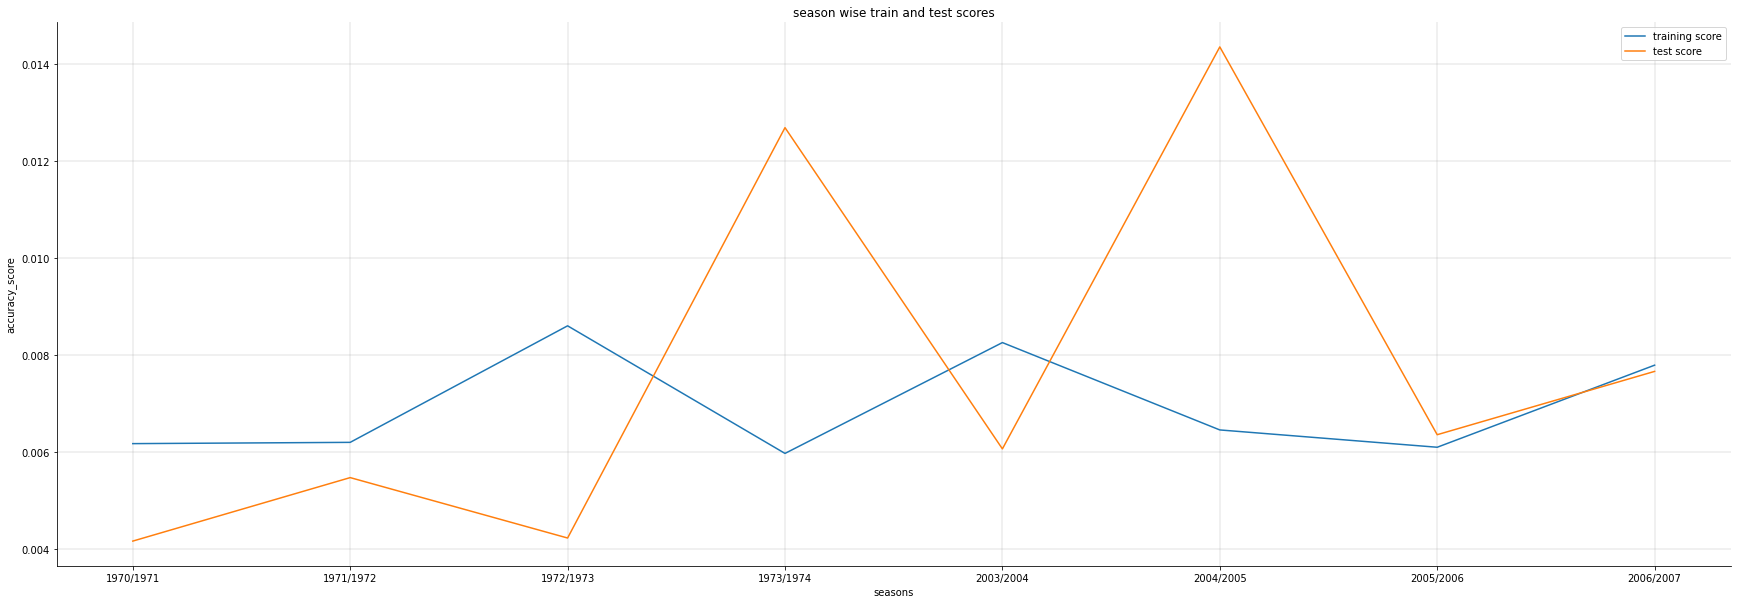

In [346]:
''' Plotting season-wise cross validation errors.

Variables:-
x - dict - season name and its encoding mapping
train_scores - list - training RMSE values
test_scores - list - test RMSE values
'''

import matplotlib as mpl
# Setting up paramters for plot design
mpl.rcParams['axes.spines.right'] = False # disable right axis
mpl.rcParams['axes.spines.top'] = False # disable top axis
plt.figure(figsize=(30,10)) # set figure size
plt.grid(
    color='gray',
    alpha=0.15,
    linewidth=1.5
) # set light gray grids

line1 = plt.plot(list(x.values()), train_scores, label='label1')
line2 = plt.plot(list(x.values()), test_scores, label='label2')

plt.xlabel('seasons')
plt.ylabel('accuracy_score')
plt.title('season wise train and test scores')
plt.legend(['training score', 'test score'])
plt.show()

### Summary

The model's training performance stays steady across seasons, whilst the test performance varies drastically.

This can be due to varying trends of xG in seasons. 

Also, further model optimisation might help achieving a steady test curve.

# Visualize Predictions

In [ ]:
''' Preparing dependent and target features for final model training.

Variables:-
encoded_final_df - DataFrame - dataframe with encoded features
'''
X = encoded_final_df.drop('goal_True',axis=1).reset_index(drop=True)
y = encoded_final_df['goal_True'].reset_index(drop=True)

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.3)

In [254]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6854479076635014, 'gamma': 1.6648101619268918, 'max_depth': 8.0, 'min_child_weight': 7.0, 'reg_alpha': 41.0, 'reg_lambda': 0.0005509776334110075}


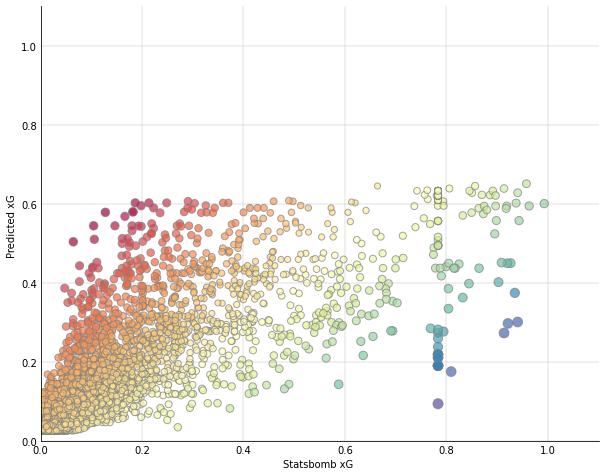

In [347]:
'''  Training the model, making predictions and plotting the test xG value against statsbomb xG.

Variables:-
best_hyperparams - dict - best hyperparamters found through cross validation
X - DataFrame - dependent features
y - Series - target features
test_xG - array - predicted xG values, i.e. the probability of class 1
'''

for param in ['max_depth','min_child_weight','reg_alpha']:
    best_hyperparams[param] = int(best_hyperparams[param])
model = xgb.XGBClassifier(tree_method="hist", colsample_bytree=0.8, gamma=1.35, max_depth=8, min_child_weight = 1, reg_alpha = 57, reg_lambda = 0.47)

model.fit(X_train.drop('statsbomb_xg',axis=1), y_train)

test_xG = model.predict_proba(X_test.drop('statsbomb_xg',axis=1))[:,1]

error = np.subtract(
    X_test['statsbomb_xg'],
    test_xG
)

plt.figure(figsize=(10,8))
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.grid(
    color='gray',
    alpha=0.15,
    linewidth=1.5
)
g=plt.scatter(
    X_test['statsbomb_xg'],
    test_xG,
    s=(plt.rcParams['lines.markersize'] * (1+np.absolute(error))) ** 2,
    c=error,
    alpha=0.7,
    edgecolors='gray',
    cmap='Spectral'
)
g.axes.set_xlabel('Statsbomb xG ')
g.axes.set_ylabel('Predicted xG ')
g.axes.spines[['right', 'top']].set_visible(False)
g.axes.tick_params(axis=u'both', which=u'both',length=0) # Credit: https://stackoverflow.com/questions/29988241/hide-ticks-but-show-tick-labels

In [257]:
print(f"TEST ROOT MEAN SQUARE ERROR: {mean_squared_error(y_true=X_test['statsbomb_xg'], y_pred=model.predict_proba(X_test.drop('statsbomb_xg',axis=1))[:,1], squared=True)}")

TEST ROOT MEAN SQUARE ERROR: 0.007230123125608064


### Summary

As derived from the scatter plot above, the improvised model has filled the gap seen in baseline model's predictions.

The RMSE error of improvised model is also very less, 0.007 , less than baseline model's RMSE

# Visualize Feature Importance

In [348]:
def improvised_proba(x,model=model):
    ''' Return probability of class 1
    
    Variables:-
    x - DataFrame - dependent features used to make predictions
    model - xgb model
    '''
    return model.predict_proba(x)[:, 1]


In [350]:
'''compute the SHAP values for the improvised model

Variables:-
X_train - DataFrame - dependent features with data used for training
improvised_proba - function - returns predicted xG
'''
background_adult = shap.maskers.Independent(X_train.drop('statsbomb_xg',axis=1), max_samples=100)
explainer = shap.Explainer(improvised_proba, background_adult)
shap_values = explainer(X_train.drop('statsbomb_xg',axis=1)[:1000])

PermutationExplainer explainer: 1001it [04:12,  3.95it/s]                          


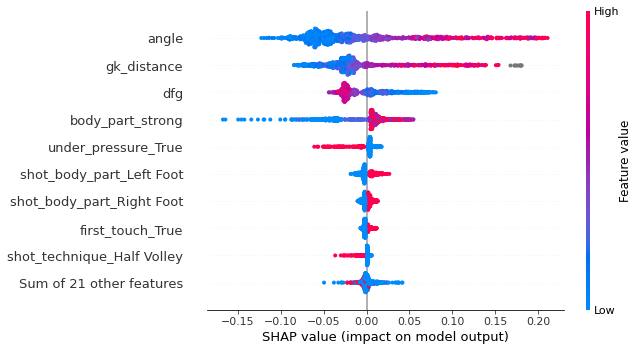

In [351]:
shap.plots.beeswarm(shap_values)

### Summary

As compared to the feature importance of baseline model, the improvised model has many top contributors.

The wide spreads in the beeswarm plot shows high importances. Also, the newly engineered features are the top contributors here.